In [112]:
import matplotlib.pyplot as plt
import numpy as np

from metpy.io import Level2File
from metpy.plots import ctables
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [113]:
# Open the file
name = '/home/CarterHumphreys/bin/data/NEXRAD/Ontario_LES_Event01/Ontario_LES_Event01-KTYX20151018_000445_V06.gz'
f = Level2File(name)

In [114]:
sweep = 0
print(f.sweeps[0][0])

(Msg31DataHdr(stid=b'KTYX', time_ms=285361, date=16727, az_num=1, az_angle=278.22052001953125, compression=0, rad_length=6864, az_spacing=1, rad_status=5, el_num=1, sector_num=1, el_angle=0.66741943359375, spot_blanking=None, az_index_mode=0.25, num_data_blks=7, vol_const_ptr=68, el_const_ptr=112, rad_const_ptr=124), VolConsts(type=b'R', name=b'VOL', size=44, major=2, minor=0, lat=43.75569534301758, lon=-75.67986297607422, site_amsl=563, feedhorn_agl=34, calib_dbz=-44.647552490234375, txpower_h=251.58445739746094, txpower_v=244.386474609375, sys_zdr=0.6174613237380981, phidp0=60.0, vcp=121, processing_status='RxR Noise'), ElConsts(type=b'R', name=b'ELV', size=12, atmos_atten=-0.012, calib_dbz0=-43.3125), RadConstsV2(type=b'R', name=b'RAD', size=28, unamb_range=466.0, noise_h=-80.50541687011719, noise_v=-80.9571762084961, nyq_vel=8.92, calib_dbz0_h=-44.12635803222656, calib_dbz0_v=-43.62846374511719), {b'REF': (DataBlockHdr(type=b'D', name=b'REF', reserved=0, num_gates=1832, first_gate=

In [115]:
sweep = 0
# First item in ray is header, which has azimuth angle
az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate
ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

vol_hdr = f.sweeps[sweep][0][4][b'VEL'][0]
vol_range = (np.arange(vol_hdr.num_gates + 1) - 0.5) * vol_hdr.gate_width + vol_hdr.first_gate
vol = np.array([ray[4][b'VEL'][1] for ray in f.sweeps[sweep]])

zdr_hdr = f.sweeps[sweep][0][4][b'ZDR'][0]
zdr_range = (np.arange(zdr_hdr.num_gates + 1) - 0.5) * zdr_hdr.gate_width + zdr_hdr.first_gate
zdr = np.array([ray[4][b'ZDR'][1] for ray in f.sweeps[sweep]])

rho_hdr = f.sweeps[sweep][0][4][b'RHO'][0]
rho_range = (np.arange(rho_hdr.num_gates + 1) - 0.5) * rho_hdr.gate_width + rho_hdr.first_gate
rho = np.array([ray[4][b'RHO'][1] for ray in f.sweeps[sweep]])

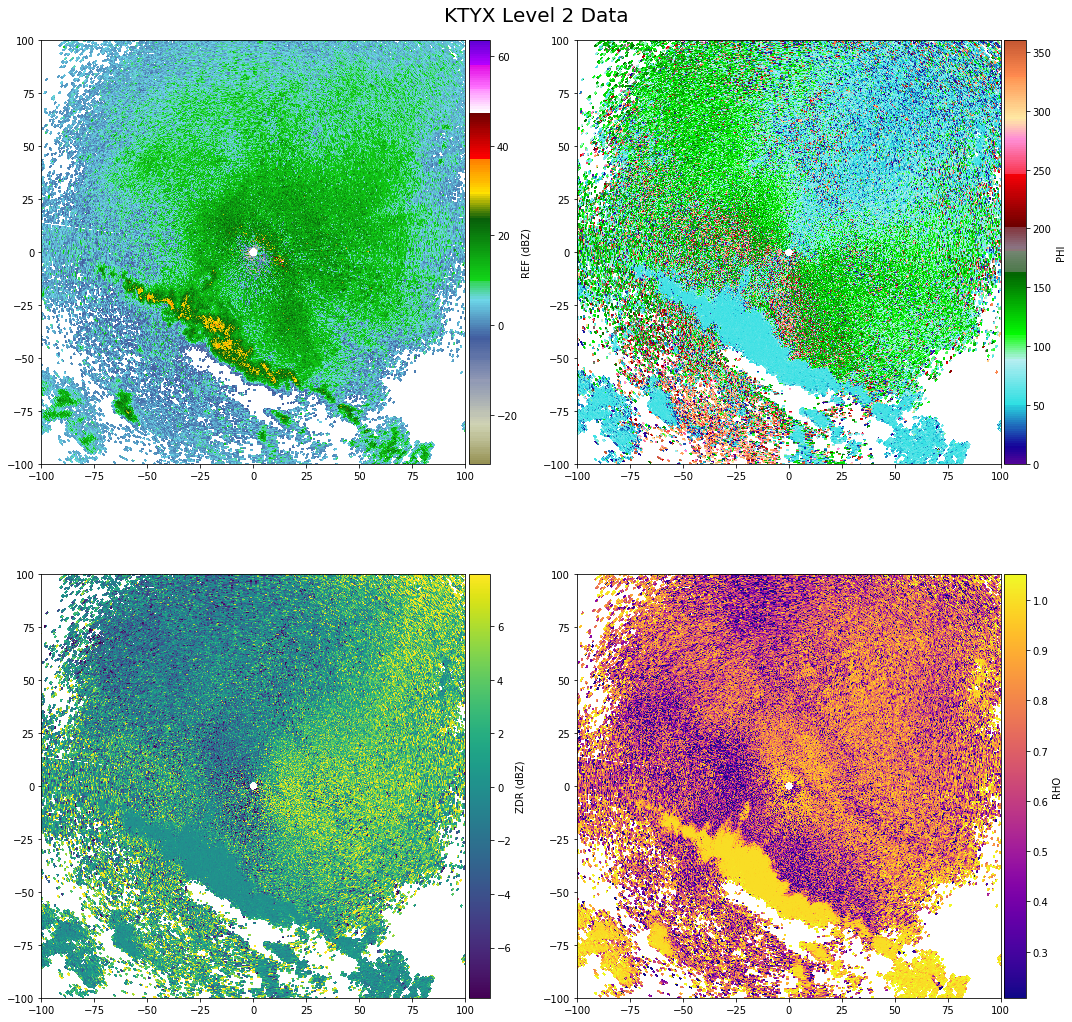

In [116]:
# Get the NWS reflectivity colortable from MetPy
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 0, 5)
vel_norm, vel_cmap = ctables.registry.get_with_steps('NWS8bitVel', 0, 5)

# Plot the data!
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for var_data, var_range, colors, lbl, ax in zip((ref, phi, zdr, rho),
                                                (ref_range, phi_range, zdr_range, rho_range),
                                                (ref_cmap, vel_cmap, 'viridis', 'plasma'),
                                                ('REF (dBZ)', 'PHI', 'ZDR (dBZ)', 'RHO'),
                                                axes.flatten()):
    # Turn into an array, then mask
    data = np.ma.array(var_data)
    data[np.isnan(data)] = np.ma.masked

    # Convert az,range to x,y
    xlocs = var_range * np.sin(np.deg2rad(az[:, np.newaxis]))
    ylocs = var_range * np.cos(np.deg2rad(az[:, np.newaxis]))

    # Define norm for reflectivity
    #norm = ref_norm if colors == ref_cmap else None

    # Plot the data
    a = ax.pcolormesh(xlocs, ylocs, data, cmap=colors, norm=None)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical', label=lbl)

    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)

plt.suptitle('KTYX Level 2 Data', fontsize=20)
plt.tight_layout()